# PROJETO I.A. DERMATOLOGISTA

O objetivo desse projeto final de conclusão do Nanodegree Engenheiro de Machine Learning, é desenvolver uma CNN (rede neural convolucional) para detectar doenças de pele, a rede consegue distinguir a forma mais mortal de câncer de pele o Melanoma, de outras duas doenças de pele benignas, Nevus e Seborrheic Keratosis. 

### Funções para Realizar o Pré-processamento dos Dados

A função load_dataset recebe como argumento o caminho relativo dos dados de treinamento, teste e validação, e retorna os mesmos dados na forma de arrays numpy, além das suas respectivas classes alvo, convertidos em codificação one-hot.

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
import cv2                
import matplotlib.pyplot as plt  
import sys,os
import tensorflow as tf

%matplotlib inline 


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    return files, targets

Using TensorFlow backend.


A função paths_to_tensor recebe como argumento os dados retornados pela função load_dataset, e os converte em uma lista de tensores, que são retornados pela função, usando a função auxiliar path_to_tensor.

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.nasnet import preprocess_input

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    # Resizes the images to the format (331,331), which is the default imageet image format
    img = image.load_img(img_path, target_size=(331,331))
    # convert PIL.Image.Image type to 3D tensor with shape (331,331,3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1,450,450,3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Carrega os Dados

Os dados de treinamento, teste e validação são carregados usando a função load_dataset, e são exibidas estatistícas referentes ao dataset.

In [4]:
# load train, test, and validation datasets

train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

# load list of disease names
disease_names = [item[11:-1] for item in sorted(glob("data/train/*/"))]

# print statistics about the dataset
for i in range(len(disease_names)):
    disease_names[i]=disease_names[i].replace("_"," ")
    disease_names[i]=disease_names[i].upper()
print('Existem %d categorias de doenças: '% len(disease_names))
print(disease_names[0],',',disease_names[1],'e',disease_names[2])
print('Existem no total de %s imagens.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('Existem %d imagens de treinamento.' % len(train_files))
print('Existem %d imagens de teste.'% len(test_files))
print('Existem %d imagens de validação.' % len(valid_files))

Existem 3 categorias de doenças: 
MELANOMA , NEVUS e SEBORRHEIC KERATOSIS
Existem no total de 2419 imagens.

Existem 1693 imagens de treinamento.
Existem 484 imagens de teste.
Existem 242 imagens de validação.


### Realiza o Pré-processamento dos Dados

Realiza o pré-processamento dos dados usando a função paths_to_tensor, para converter os dados de treinamento, teste e validação em tensores, além de dividir todos os valores armazenados nos tensores por 255, para normalizar os dados para alimentar a rede neural.


In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [01:30<00:00,  5.37it/s]


### Salva os Dados

Salva os dados pré-processados, para que não seja necessário realizar todo o pré-processamento, toda vez que o projeto for executado.

In [25]:
np.savez_compressed('tensors/tensors', train=train_tensors, test=test_tensors, valid=valid_tensors)
np.savez_compressed('tensors/targets', train=train_targets, test=test_targets, valid=valid_targets)

## Transferência de Aprendizado

Abaixo seguem todas as etapas necessárias para realizar a técnica da Transferência de Aprendizado.

### Carrega os Dados Salvos

Carrega os dados de treinamento, validação e teste, salvos na forma de tensores.

In [6]:
#COMEÇAR A PARTIR DAQUI!!!
tensors = np.load('tensors/tensors.npz')
train_tensors = tensors['train']
valid_tensors = tensors['valid']
test_tensors = tensors['test']

Carrega os rótulos de todos dados.

In [7]:
targets = np.load('tensors/targets.npz')
train_targets = targets['train']
valid_targets = targets['valid']
test_targets = targets['test']

Carrega os recursos de gargalo que serão usados para realizar a transferência de aprendizado.

In [8]:
bottleneck_features = np.load('bottleneck_features/NASNetLarge.npz')
train_NASNet = bottleneck_features['train']
valid_NASNet = bottleneck_features['valid']
test_NASNet = bottleneck_features['test']

### Cria o Modelo Topo

Define a arquitetura da rede neural, que posteriormente será usada como a camada densa final, na etapa de ajuste fino.

In [9]:
n_classes=len(disease_names) # número de classes
p_dropout = 0.50 # probabilidade de dropout
n_hidden = 8064 # número de neurônios na camada primeira oculta

NASNet_top = tf.keras.models.Sequential()
NASNet_top.add(tf.keras.layers.GlobalAveragePooling2D(input_shape=train_NASNet.shape[1:]))
NASNet_top.add(tf.keras.layers.Dense(n_hidden))
NASNet_top.add(tf.keras.layers.Activation('relu'))
NASNet_top.add(tf.keras.layers.BatchNormalization())
NASNet_top.add(tf.keras.layers.Dropout(p_dropout))
NASNet_top.add(tf.keras.layers.Dense(n_classes, activation='sigmoid'))
NASNet_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8064)              32522112  
_________________________________________________________________
activation_1 (Activation)    (None, 8064)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8064)              32256     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8064)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 24195     
Total params: 32,578,563
Trainable params: 32,562,435
Non-trainable params: 16,128
___________________________________________________________

### Define a Função de Perda

In [15]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [16]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Compila o Modelo 

In [24]:
decay=1e-6

opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False, clipvalue=0.5)

NASNet_top.compile(loss=dice_coef_loss, optimizer=opt, metrics=[dice_coef])

### Treina o Modelo

In [27]:

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/weights.best.NASNet_TOP.hdf5', verbose=1, save_best_only=True)

batch_size = 32
epochs = 10

NASNet_top.fit(train_NASNet, train_targets, 
          validation_data=(valid_NASNet, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


Train on 1693 samples, validate on 242 samples
Epoch 1/10
1693/1693 [==============================] - ETA: 1:20 - loss: -0.7124 - dice_coef: 0.71 - ETA: 1:00 - loss: -0.8069 - dice_coef: 0.80 - ETA: 52s - loss: -0.8422 - dice_coef: 0.8422 - ETA: 47s - loss: -0.8566 - dice_coef: 0.856 - ETA: 45s - loss: -0.8292 - dice_coef: 0.829 - ETA: 42s - loss: -0.8195 - dice_coef: 0.819 - ETA: 41s - loss: -0.8020 - dice_coef: 0.802 - ETA: 39s - loss: -0.8124 - dice_coef: 0.812 - ETA: 38s - loss: -0.8076 - dice_coef: 0.807 - ETA: 36s - loss: -0.8133 - dice_coef: 0.813 - ETA: 35s - loss: -0.8107 - dice_coef: 0.810 - ETA: 34s - loss: -0.8049 - dice_coef: 0.804 - ETA: 33s - loss: -0.8130 - dice_coef: 0.813 - ETA: 32s - loss: -0.8132 - dice_coef: 0.813 - ETA: 31s - loss: -0.8178 - dice_coef: 0.817 - ETA: 31s - loss: -0.8229 - dice_coef: 0.822 - ETA: 30s - loss: -0.8197 - dice_coef: 0.819 - ETA: 29s - loss: -0.8121 - dice_coef: 0.812 - ETA: 28s - loss: -0.8165 - dice_coef: 0.816 - ETA: 27s - loss: -0.81

1693/1693 [==============================] - ETA: 40s - loss: -0.8356 - dice_coef: 0.835 - ETA: 39s - loss: -0.7742 - dice_coef: 0.774 - ETA: 38s - loss: -0.7664 - dice_coef: 0.766 - ETA: 37s - loss: -0.7902 - dice_coef: 0.790 - ETA: 37s - loss: -0.8044 - dice_coef: 0.804 - ETA: 36s - loss: -0.8221 - dice_coef: 0.822 - ETA: 35s - loss: -0.8316 - dice_coef: 0.831 - ETA: 34s - loss: -0.8277 - dice_coef: 0.827 - ETA: 34s - loss: -0.8231 - dice_coef: 0.823 - ETA: 33s - loss: -0.8230 - dice_coef: 0.823 - ETA: 32s - loss: -0.8239 - dice_coef: 0.823 - ETA: 31s - loss: -0.8240 - dice_coef: 0.824 - ETA: 31s - loss: -0.8247 - dice_coef: 0.824 - ETA: 30s - loss: -0.8307 - dice_coef: 0.830 - ETA: 29s - loss: -0.8332 - dice_coef: 0.833 - ETA: 28s - loss: -0.8386 - dice_coef: 0.838 - ETA: 27s - loss: -0.8383 - dice_coef: 0.838 - ETA: 27s - loss: -0.8417 - dice_coef: 0.841 - ETA: 26s - loss: -0.8450 - dice_coef: 0.845 - ETA: 25s - loss: -0.8431 - dice_coef: 0.843 - ETA: 24s - loss: -0.8441 - dice_coe

1693/1693 [==============================] - ETA: 52s - loss: -0.8126 - dice_coef: 0.812 - ETA: 51s - loss: -0.8558 - dice_coef: 0.855 - ETA: 50s - loss: -0.8529 - dice_coef: 0.852 - ETA: 50s - loss: -0.8432 - dice_coef: 0.843 - ETA: 49s - loss: -0.8439 - dice_coef: 0.843 - ETA: 47s - loss: -0.8467 - dice_coef: 0.846 - ETA: 46s - loss: -0.8449 - dice_coef: 0.844 - ETA: 44s - loss: -0.8456 - dice_coef: 0.845 - ETA: 42s - loss: -0.8455 - dice_coef: 0.845 - ETA: 41s - loss: -0.8381 - dice_coef: 0.838 - ETA: 39s - loss: -0.8352 - dice_coef: 0.835 - ETA: 38s - loss: -0.8388 - dice_coef: 0.838 - ETA: 37s - loss: -0.8388 - dice_coef: 0.838 - ETA: 35s - loss: -0.8429 - dice_coef: 0.842 - ETA: 34s - loss: -0.8454 - dice_coef: 0.845 - ETA: 34s - loss: -0.8499 - dice_coef: 0.849 - ETA: 33s - loss: -0.8506 - dice_coef: 0.850 - ETA: 32s - loss: -0.8544 - dice_coef: 0.854 - ETA: 32s - loss: -0.8473 - dice_coef: 0.847 - ETA: 31s - loss: -0.8499 - dice_coef: 0.849 - ETA: 30s - loss: -0.8548 - dice_coe

1693/1693 [==============================] - ETA: 44s - loss: -0.8600 - dice_coef: 0.860 - ETA: 43s - loss: -0.8818 - dice_coef: 0.881 - ETA: 41s - loss: -0.8746 - dice_coef: 0.874 - ETA: 40s - loss: -0.8824 - dice_coef: 0.882 - ETA: 40s - loss: -0.8848 - dice_coef: 0.884 - ETA: 39s - loss: -0.8620 - dice_coef: 0.862 - ETA: 38s - loss: -0.8727 - dice_coef: 0.872 - ETA: 37s - loss: -0.8618 - dice_coef: 0.861 - ETA: 36s - loss: -0.8723 - dice_coef: 0.872 - ETA: 35s - loss: -0.8722 - dice_coef: 0.872 - ETA: 34s - loss: -0.8642 - dice_coef: 0.864 - ETA: 34s - loss: -0.8652 - dice_coef: 0.865 - ETA: 33s - loss: -0.8643 - dice_coef: 0.864 - ETA: 32s - loss: -0.8613 - dice_coef: 0.861 - ETA: 31s - loss: -0.8598 - dice_coef: 0.859 - ETA: 30s - loss: -0.8601 - dice_coef: 0.860 - ETA: 29s - loss: -0.8643 - dice_coef: 0.864 - ETA: 28s - loss: -0.8585 - dice_coef: 0.858 - ETA: 27s - loss: -0.8612 - dice_coef: 0.861 - ETA: 27s - loss: -0.8598 - dice_coef: 0.859 - ETA: 26s - loss: -0.8582 - dice_coe

### Carrega os Pesos do Modelo com o Melhor Desempenho

In [43]:
NASNet_top.load_weights('saved_models/weights.best.NASNet_TOP.hdf5')

### Métricas de Avaliação

Abaixo seguem as principais métricas usadas para avaliar o modelo. 

### Acurácia

In [44]:
# obtain the predicted disease class index for each image in the test set
NASNet_predictions = [np.argmax(NASNet_top.predict(np.expand_dims(feature, axis=0))) for feature in test_NASNet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(NASNet_predictions)==np.argmax(test_targets, axis=1))/len(NASNet_predictions)
print('Acurácia no Conjunto de Testes: %.4f%%' % test_accuracy)

Acurácia no Conjunto de Testes: 77.8926%


### Salva as Previsões do Modelo no Arquivo sample_predictions.csv

In [45]:
path="data/test/"

Id=[]
task_1=[]
task_2=[]

for diretory in os.listdir(path):
    for (img,index) in zip(os.listdir(path+diretory),NASNet_predictions):
        Id.append(path+diretory+'/'+img)
        #se for melanoma
        if index==0:
            task_1.append(1)
            task_2.append(0)
        #se for nevus
        if index==1:
            task_1.append(0)
            task_2.append(0)
        #se for seborrheic keratosis
        if index==2:
            task_1.append(0)
            task_2.append(1)
        
raw_data = {'Id': Id,'task_1':task_1, 'task_2':task_2}
df = pd.DataFrame(raw_data, columns = ['Id', 'task_1', 'task_2'])
df.to_csv('sample_predictions.csv',index = False)

In [46]:
from sklearn.metrics import fbeta_score, precision_score, recall_score
from get_results import plot_roc_auc, plot_confusion_matrix

In [47]:
test_predictions = np_utils.to_categorical(NASNet_predictions, 3)

### Precisão

In [48]:
test_precision=precision_score(test_targets, test_predictions, average='weighted')
test_precision*=100
print('Precisão no Conjunto de Testes: %.4f%%' % test_precision)

Precisão no Conjunto de Testes: 75.1341%


### Revocação (Recall)

In [49]:
test_recall=recall_score(test_targets, test_predictions, average='weighted')
#recall importante
test_recall*=100
print('Revocação no Conjunto de Testes: %.4f%%' % test_recall)

Revocação no Conjunto de Testes: 77.8926%


### FBeta Score

In [50]:
#Calcula fbeta score, usando beta igual a 4

Beta=4

test_fbeta_score=fbeta_score(test_targets, test_predictions, Beta, average='weighted')
test_fbeta_score*=100
print('F4 Score no Conjunto de Testes: %.4f%%' % test_fbeta_score)

F4 Score no Conjunto de Testes: 77.4884%


### Curva ROC

C:\Users\mathe\Anaconda3\envs\ITALO\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\mathe\Anaconda3\envs\ITALO\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


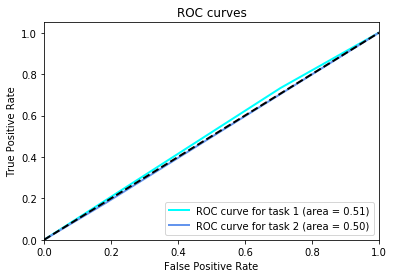

Category 1 Score: 0.513
Category 2 Score: 0.497
Category 3 Score: 0.505


In [51]:
preds_path='sample_predictions.csv'

truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv(preds_path)
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)

### Matriz de Confusão

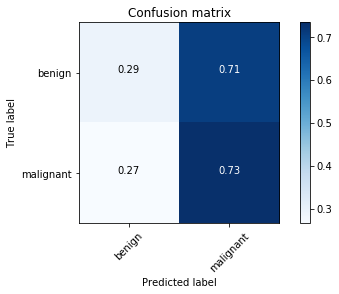

In [52]:
# plot confusion matrix
thresh=0.4
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

## Executa o Ajuste Fino

### Cria o Modelo Base

Cria uma instância do modelo NASNetLarge do Keras, pré-inicializada com os pesos da imagenet, cuja função é ser usado como classificador base na etapa do ajuste fino.

In [55]:
NASNet_base=tf.keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=train_tensors.shape[1:])

### Constrói o Modelo

Define a arquitetura da modelo final, que é composta pelos modelos NASNet_base e NASNet_top, definidos anteriormente.

In [16]:
NASNet_model = tf.keras.models.Sequential()
NASNet_model.add(NASNet_base)
NASNet_model.add(NASNet_top)
NASNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 32578563  
Total params: 117,495,381
Trainable params: 117,282,585
Non-trainable params: 212,796
_________________________________________________________________


### Define quais Camadas do Modelo Poderão ser Treinadas

Define as últimas 94 camadas do modelo como treináveis, que são compostas pelos 2 últimos blocos convolucionais da CNN NASNet, incluindo a última camada densamente conectada, responsável por realizar as predições.

In [18]:
for layer in NASNet_model.layers[-94:]: 
    layer.trainable = True


### Compila o Modelo 

In [19]:
from keras import optimizers

decay=1e-7

opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False, clipvalue=0.5)

NASNet_model.compile(loss=dice_coef_loss, optimizer=opt, metrics=[dice_coef])

### Treina o Modelo

In [ ]:
 
batch_size = 32

epochs=1

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/weights.best.NASNet_model.hdf5', verbose=1, save_best_only=True)



datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=270,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

datagen.fit(train_tensors)

# fine-tune the model

NASNet_model.fit_generator(
        datagen.flow(train_tensors,train_targets,batch_size=batch_size),
        steps_per_epoch=train_tensors.shape[0]//batch_size,
        epochs=epochs,
        verbose=1,
        callbacks=[checkpointer],
        validation_data=(valid_tensors,valid_targets),
        validation_steps=valid_tensors.shape[0]//batch_size)


Epoch 1/1
26/52 [==============>...............] - ETA: 7:04:44 - loss: -0.9009 - dice_coef: 0.900 - ETA: 6:59:27 - loss: -0.8581 - dice_coef: 0.858 - ETA: 6:30:53 - loss: -0.8662 - dice_coef: 0.866 - ETA: 6:13:19 - loss: -0.8617 - dice_coef: 0.861 - ETA: 6:00:47 - loss: -0.8476 - dice_coef: 0.847 - ETA: 5:49:23 - loss: -0.8471 - dice_coef: 0.847 - ETA: 5:39:17 - loss: -0.8521 - dice_coef: 0.852 - ETA: 5:29:41 - loss: -0.8507 - dice_coef: 0.850 - ETA: 5:22:26 - loss: -0.8441 - dice_coef: 0.844 - ETA: 5:17:36 - loss: -0.8381 - dice_coef: 0.838 - ETA: 5:10:26 - loss: -0.8417 - dice_coef: 0.841 - ETA: 5:02:12 - loss: -0.8361 - dice_coef: 0.836 - ETA: 4:55:26 - loss: -0.8326 - dice_coef: 0.832 - ETA: 4:48:53 - loss: -0.8330 - dice_coef: 0.833 - ETA: 4:42:58 - loss: -0.8319 - dice_coef: 0.831 - ETA: 4:35:49 - loss: -0.8290 - dice_coef: 0.829 - ETA: 4:28:27 - loss: -0.8264 - dice_coef: 0.826 - ETA: 4:21:24 - loss: -0.8259 - dice_coef: 0.825 - ETA: 4:14:21 - loss: -0.8253 - dice_coef: 0.825 -

### Carrega os Pesos do Modelo com o Melhor Desempenho no Conjunto de Validação

In [ ]:
NASNet_model.load_weights('saved_models/weights.best.NASNet_model.hdf5')

### Testa o Modelo Final

In [36]:
# obtain the predicted disease class index for each image in the test set
NASNet_predictions = [np.argmax(NASNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(NASNet_predictions)==np.argmax(test_targets, axis=1))/len(NASNet_predictions)
print('Acurácia no Conjunto de Testes: %.4f%%' % test_accuracy)

Acurácia no Conjunto de Testes: 61.9835%


### Funcão para Realizar as Previsões

A função abaixo recebe como parâmetro de entrada um modelo pré-treinado e um diretório, realiza as previsões, e retorna as previsões do modelo e os rótulos corretos.

In [ ]:
def NASNet_predict_diseases(model,image_path):
    test_files, test_targets = load_dataset(image_path)
    test_tensors = paths_to_tensor(test_files).astype('float32')/255
    bf_prediction=model.predict(test_tensors)
    predictions=[np.argmax(NASNet_top.predict(np.expand_dims(feature, axis=0))) for feature in bf_prediction]
    test_predictions=[disease_names[prediction] for prediction in predictions]
    test_targets=[disease_names[np.argmax(prediction)] for prediction in test_targets]
    return test_predictions, test_targets

### Demonstração

A demonstração abaixo realiza previsões de todas as imagens no diretório image_path

In [ ]:
image_path="data/test"

predictions,targets=NASNet_predict_diseases(NASNet_base,image_path)


100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [01:27<00:00,  5.51it/s]


### Calcula a Acurácia 

In [ ]:
accuracy = 100*np.sum(np.array(predictions)==np.array(targets))/len(predictions)
print('Acurácia no Conjunto de Testes: %.4f%%' % accuracy)

### Mostra as Previsões de todas as Imagens do Diretório, Incluíndo suas Respectivas Classes Corretas

In [ ]:
image_path="data/test"
image_path=image_path+"/"
cont=0

for dir_ in os.listdir(image_path):
    for img in os.listdir(image_path+dir_):
        full_path=image_path+dir_+"/"+img
        photo = cv2.imread(full_path)
        cv_rgb = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        title=full_path.split("/")
        title=title[-2]
        title=title.replace("_"," ")
        title=title.upper()
        prediction=predictions[cont]
        cont+=1
        plt.title('Classe Correta = '+title)
        plt.xlabel('Classe Prevista = '+prediction)
        plt.show()
    


### Conclusão

A CNN desenvolvida nesse projeto final de conclusão de curso alcançou uma acurácia de 77.8926% no conjunto de testes, resultado significativamente superior ao modelo de refêrencia que é de 71%, embora não tenha conseguido bons resultados na curva ROC e na matriz de confusão, conseguiu atingir bons resultados nas demais métricas de avaliação.